# MLP vs CNN 
### by Pio Lauren T. Mendoza 

This notebook demonstrates the performance difference of a between MLP and CNN with respect to varying hyperparameters.
Different MLP and CNN models will be used to classify the CIFAR10 dataset.

We must first import the necessary modules (i.e. maplotlib.pylot, numpy, and tensorflow)

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import inspect
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import cifar10

The machine used for running this notebook has a good gpu. The list of of gpu of the machine can be check by running the method below.

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print(f"Number of GPUs: {len(gpus)}")
print("List of GPUs:", *gpus, sep='\n\t-')

Number of GPUs: 1
List of GPUs:
	-PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Loading CIFAR10 Dataset
Data will be loaded from tf.keras.dataset

In [3]:
(xTrain, yTrain), (xTest, yTest) = cifar10.load_data()
print("Number of samples for training: ", xTrain.shape[0])
print("Number of samples for testing: ", xTest.shape[0])
print("Input image size: ", xTrain.shape[1:])

Number of samples for training:  50000
Number of samples for testing:  10000
Input image size:  (32, 32, 3)


## Data Preprocessing
For the input data set the image the pixels will normalize (i.e. dividing each element by 255)

In [4]:
xTrain, xTest = xTrain/255.0, xTest/255.0

## Converting Labels into one-hot encoding
Each interger label will conver to ins one hot encoding. 
(e.g. for labels from 0 to 3, 0 will converted to [1 0 0 0])

In [5]:
yTrain, yTest = to_categorical(yTrain), to_categorical(yTest)

Retyping the code for each model will be tiresome and it will also make this notebook bulky. Making a class that will give different model instances will be a better way.
There will be two classes MLP and CNN each will have a its own method for creating different model, training, and printing the accuracy.

## MLP Class

In [6]:
class MLP:
    """
    batch_size
    n_units
    epochs
    activation
    nLabels
    loss
    inputSize # per element input size
    """    
    def __init__(self, batch_size, n_units, epochs, activation, loss, xtrain, ytrain, xtest, ytest):
        self.__batchSize = batch_size
        self.__nUnits = n_units
        self.__epochs = epochs
        self.__activation = activation
        self.__loss = loss
        self.__nLabels = len(yTrain[0])
        self.__size = xTrain.shape
        self.__inputSize = self.__size[1] * self.__size[2] * self.__size[3]
        self.__xTrain = np.reshape(xtrain, [-1, self.__inputSize])
        self.__xTest = np.reshape(xtest, [-1, self.__inputSize])
        self.__yTrain = ytrain
        self.__yTest = ytest
    
    def model3L(self):
        inputs = Input(shape=(self.__inputSize,))
        x = Dense(self.__nUnits, activation = self.__activation)(inputs)
        x = Dense(self.__nUnits, activation = self.__activation)(x)
        outputs = Dense(self.__nLabels, activation = 'softmax')(x)
        self.__model = Model(inputs=inputs, outputs=outputs, name = '3-Layer')
    
    def printModelSummary(self):
        self.__model.summary()
        
    def printModelPlot(self):
        plot_model(self.__model)
        
    def modelCompile(self):
        self.__model.compile(loss=self.__loss,
                             optimizer='sgd',
                             metrics=['accuracy'])
        
    def modelTrain(self):
        self.__history = self.__model.fit(self.__xTrain,
                                          self.__yTrain, 
                                          validation_data=(self.__xTest, self.__yTest), 
                                          epochs = self.__epochs,
                                          batch_size = self.__batchSize,
                                          verbose = True)
        
    def modelEvaluate(self):
        self.__lossValue, self.__acc = self.__model.evaluate(self.__xTest, 
                                                        self.__yTest, 
                                                        batch_size=self.__batchSize, 
                                                        verbose = False)
        
    def printAccuracyAndLoss(self):
        print("\nTest accuracy: {:.1f}%".format((100.0 * self.__acc)))
        print("Test loss: {:.1f}".format(self.__lossValue))
        
    def plotCrossEntrophy(self):
        plt.plot(self.__history.history['loss'], label='Train loss')
        plt.plot(self.__history.history['val_loss'], label='Test loss')
        #plt.plot(history.history['val_acc'], label='Test accuracy')
        plt.title('Train and Test Loss')
        plt.ylabel('Cross-Entropy')
        plt.xlabel('Epochs')
        plt.legend(loc="upper right")
        plt.show()
        
    def plotAccuracy(self):
        plt.plot(self.__history.history['accuracy'], label='Train accuracy')
        plt.plot(self.__history.history['val_accuracy'], label='Test accuracy')
        plt.title('Train and Test Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        plt.legend(loc="lower right")
        plt.show()    
        
    def run(self):
        self.modelCompile()
        self.modelTrain()
        self.modelEvaluate()
        print(self)
        self.printAccuracyAndLoss()
    
    def __str__(self):
        return inspect.cleandoc(f"""Model: {self.__model.name}
        Batch Size: {self.__batchSize}
        Hidden Units: {self.__nUnits}
        Epochs: {self.__epochs}
        Activation Function: {self.__activation}
        Loss Function: {self.__loss}""")
        
        

## Excuting different models for MLP
The hyperparameters for each model will be varied and each model will analyzed based on its accuracy

This could have been the easy way of finding the best model but impractical. I don't have the computing power.
```python
batchSizeList = [32, 64, 128, 256]
nUnitsList = [64, 128, 256, 512]
epochsList = [100, 1500, 1000]
loss = "categorical_crossentropy"
activation = "relu"
hyperParametersList = [{"batchSize": batchSize, "nUnits": nUnits, "epochs": epochs} 
                   for batchSize in batchSizeList
                   for nUnits in nUnitsList
                   for epochs in epochsList]
models = []
for hyperParameters in hyperParametersList:
    currModel = MLP(hyperParameters["batchSize"], hyperParameters["nUnits"], 
                    hyperParameters["epochs"], activation, loss, xTrain, yTrain, xTest, yTest)
    currModel.model3L()
    currModel.run()
    models.append(currModel)
```

## CNN Class

In [7]:
class CNN:
    """
    batch_size
    n_units
    epochs
    activation
    nLabels
    loss
    inputSize # per element input size
    """    
    def __init__(self, batch_size, kernel_size, n_filter, epochs, activation, loss, xtrain, ytrain, xtest, ytest):
        self.__batchSize = batch_size
        self.__kernel_size = kernel_size
        self.__n_filter = n_filter
        self.__epochs = epochs
        self.__activation = activation
        self.__loss = loss
        self.__nLabels = len(yTrain[0])
        self.__inputSize = xTrain.shape[1:]
        self.__xTrain = xtrain
        self.__xTest = xtest
        self.__yTrain = ytrain
        self.__yTest = ytest
    
    def model4L(self):
        inputs = Input(shape=(self.__inputSize))
        x = Conv2D(filters=self.__n_filter,
           kernel_size=self.__kernel_size,
           activation=self.__activation,
           padding='same')(inputs)
        x = MaxPooling2D()(x)
        x = Conv2D(filters=self.__n_filter,
                   kernel_size=self.__kernel_size,
                   activation=self.__activation,
                   padding='same')(x)
        x = MaxPooling2D()(x)
        x = Conv2D(filters=self.__n_filter,
                   kernel_size=self.__kernel_size,
                   activation=self.__activation,
                   padding='same')(x)
        x = Flatten()(x)
        outputs = Dense(self.__nLabels, activation = 'softmax')(x)
        self.__model = Model(inputs=inputs, outputs=outputs, name = '4-Layer')
        
    def model10L(self):
        inputs = Input(shape=(self.__inputSize))
        x = Conv2D(filters=self.__n_filter,
           kernel_size=self.__kernel_size,
           activation=self.__activation,
           padding='same')(inputs)
        for i in range(4):
            x = Conv2D(filters=self.__n_filter,
                       kernel_size=self.__kernel_size,
                       activation=self.__activation,
                       padding='same')(x)
        for i in range(3):
            x = Conv2D(filters=self.__n_filter,
                       kernel_size=self.__kernel_size,
                       activation=self.__activation,
                       padding='same')(x)
            x = MaxPooling2D()(x)
        x = Conv2D(filters=self.__n_filter,
                   kernel_size=self.__kernel_size,
                   activation=self.__activation,
                   padding='same')(x)
        x = Flatten()(x)
        outputs = Dense(self.__nLabels, activation = 'softmax')(x)
        self.__model = Model(inputs=inputs, outputs=outputs, name = '10-Layer')
    
    def printModelSummary(self):
        self.__model.summary()
        
    def printModelPlot(self):
        plot_model(self.__model)
        
    def modelCompile(self):
        self.__model.compile(loss=self.__loss,
                             optimizer='sgd',
                             metrics=['accuracy'])
        
    def modelTrain(self):
        self.__history = self.__model.fit(self.__xTrain,
                                          self.__yTrain, 
                                          validation_data=(self.__xTest, self.__yTest), 
                                          epochs = self.__epochs,
                                          batch_size = self.__batchSize,
                                          verbose = False)
        
    def modelEvaluate(self):
        self.__lossValue, self.__acc = self.__model.evaluate(self.__xTest, 
                                                        self.__yTest, 
                                                        batch_size=self.__batchSize, 
                                                        verbose = False)
        
    def printAccuracy(self):
        print("\nTest accuracy: {:.1f}%".format((100.0 * self.__acc)))
        
    def plotCrossEntrophy(self):
        plt.plot(self.__history.history['loss'], label='Train loss')
        plt.plot(self.__history.history['val_loss'], label='Test loss')
        #plt.plot(history.history['val_acc'], label='Test accuracy')
        plt.title('Train and Test Loss')
        plt.ylabel('Cross-Entropy')
        plt.xlabel('Epochs')
        plt.legend(loc="upper right")
        plt.show()
        
    def plotAccuracy(self):
        plt.plot(self.__history.history['accuracy'], label='Train accuracy')
        plt.plot(self.__history.history['val_accuracy'], label='Test accuracy')
        plt.title('Train and Test Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        plt.legend(loc="lower right")
        plt.show()    
        
    def run(self):
        self.modelCompile()
        self.modelTrain()
        self.modelEvaluate()
        print(self)
        self.printAccuracy()
    
    def __str__(self):
        return inspect.cleandoc(f"""Model: {self.__model.name}
        Batch Size: {self.__batchSize}
        Kernel Size: {self.__kernel_size}
        Number of filters: {self.__n_filter}
        Epochs: {self.__epochs}
        Activation Function: {self.__activation}
        Loss Function: {self.__loss}""")
        
        

## Excuting different models for CNN
The hyperparameters for each model will be varied and each model will analyzed based on its accuracy

Model: "4-Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0   

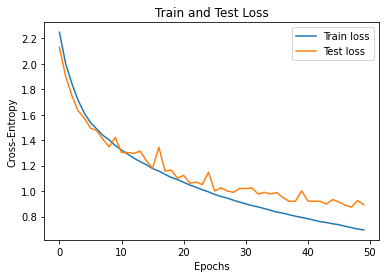

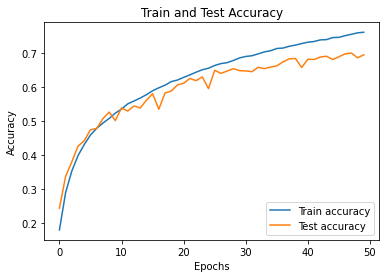

In [8]:
batch_size = 128
kernel_size = 3
filters = 64
epochs = 50
loss = 'categorical_crossentropy'
activation = 'relu'

model1 = CNN(batch_size, kernel_size, filters,
                    epochs, activation, loss, xTrain, yTrain, xTest, yTest)
model1.model4L()
model1.printModelSummary()
model1.run()
model1.plotCrossEntrophy()
model1.plotAccuracy()
model1.printModelPlot()

Model: "4-Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0   

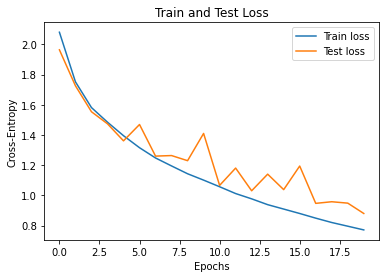

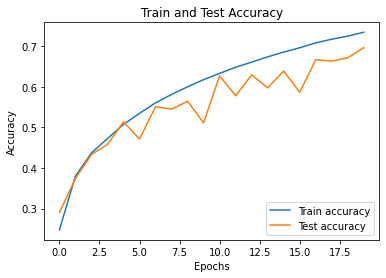

In [9]:
batch_size = 64
kernel_size = 3
filters = 128
epochs = 20
loss = 'categorical_crossentropy'
activation = 'relu'

model1 = CNN(batch_size, kernel_size, filters,
                    epochs, activation, loss, xTrain, yTrain, xTest, yTest)
model1.model4L()
model1.printModelSummary()
model1.run()
model1.plotCrossEntrophy()
model1.plotAccuracy()
model1.printModelPlot()

Model: "10-Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        369

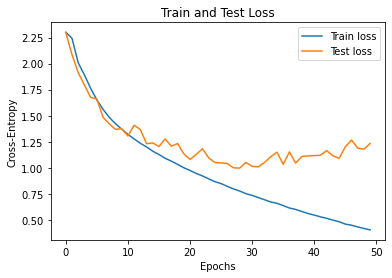

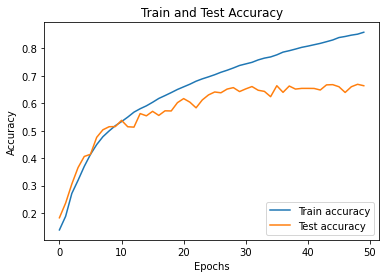

In [10]:
batch_size = 128
kernel_size = 3
filters = 64
epochs = 50
loss = 'categorical_crossentropy'
activation = 'relu'

model1 = CNN(batch_size, kernel_size, filters,
                    epochs, activation, loss, xTrain, yTrain, xTest, yTest)
model1.model10L()
model1.printModelSummary()
model1.run()
model1.plotCrossEntrophy()
model1.plotAccuracy()
model1.printModelPlot()

Model: "10-Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 128)       147

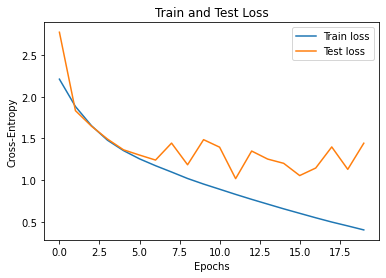

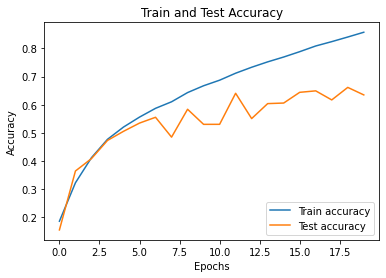

In [11]:
batch_size = 64
kernel_size = 3
filters = 128
epochs = 20
loss = 'categorical_crossentropy'
activation = 'relu'

model1 = CNN(batch_size, kernel_size, filters,
                    epochs, activation, loss, xTrain, yTrain, xTest, yTest)
model1.model10L()
model1.printModelSummary()
model1.run()
model1.plotCrossEntrophy()
model1.plotAccuracy()
model1.printModelPlot()